In [5]:
import pyspark
import os
import functools
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.sql.types import BooleanType, DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from boto3.session import Session

In [6]:
spark = pyspark.sql.SparkSession.builder.config("spark.driver.memory", "30g").appName('final').getOrCreate()
sc = spark.sparkContext

### Set up Amazon S3 Credentials (Note:- Our access and secret keys are removed for security purposes)

In [7]:
ACCESS_KEY = 'MYACCESSKEY'
SECRET_KEY = 'MYSECRETKEY'
BUCKET_NAME = 'yelpbigdata'
PREFIX = 'root'
MAX_FILES_READ = 4

In [9]:
session = Session(aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)

In [11]:
s3 = session.resource('s3')
my_bucket = s3.Bucket(BUCKET_NAME)
print(my_bucket)

s3.Bucket(name='yelpbigdata')


In [12]:
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", ACCESS_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SECRET_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3-eu-west-1.amazonaws.com")

### Download the Data from the S3 Bucket and load into the dataframe

In [13]:
s3
my_bucket.download_file('yelp_business.csv',"business.csv")

s3.ServiceResource()

In [15]:
data = spark.read.format("com.databricks.spark.csv").\
            option("wholeFile", "true").\
            option("header", "true").\
            option("inferSchema", "true").\
            option("delimiter",",").\
            option("encoding", "ISO-8859-1").\
            option("charset", "ISO-8859-1").\
            option("quote", "\"").\
            option("escape", "\"").\
            load("/content/business.csv")

In [16]:
@F.udf(returnType=BooleanType())
def isRestaurant(categories):
    return 'Restaurants' in categories

data = data.filter(isRestaurant('categories'))

In [17]:
data = data.withColumnRenamed('name', 'BusinessName')

In [18]:
trainingColumns = []

for column in data.columns:
    if len(column) > 12 and column[:11] == 'attributes.':
        data = data.withColumnRenamed(column, column[11:])
        trainingColumns.append(column[11:])
    elif len(column) > 6 and column[:6] == 'hours.':
        data = data.withColumnRenamed(column, column[6:])

In [19]:
nonBoolCols = ['AgesAllowed', \
                 'Alcohol', \
                 'BYOBCorkage', \
                 'NoiseLevel', \
                 'RestaurantsAttire', \
                 'Smoking', \
                 'WiFi']

In [20]:
def mapper(a):
    return a[0].split()[0].strip("\"\':{}u").split()
    
def reducer(aye, bee):
    for b in bee:
        if not b.lower() in aye and not b.lower() in ['na', 'true', 'false', '']:
            aye.append(b.lower())
    return aye

In [21]:
newTrainingCols = []
negValues = ['na', 'none', 'None', 'False']
posValues = ['True']

for col in nonBoolCols:
    newCols = data.select([col]).rdd.map(list)
    newCols = newCols.map(lambda a: mapper(a)).reduce(lambda a, b: reducer(a, b))
    newCols = list(filter(lambda a: a.lower() not in negValues, newCols))
    newCols = list(filter(lambda a: a.lower() not in posValues, newCols))

    for newCol in newCols:
    
        @F.udf(returnType=DoubleType())
        def myEncoder(x):
            if (x.lower() == newCol or newCol in x.lower()):
                for n in negValues:
                    if n == x or n in x:
                        return 0.0
                return 1.0
            else:
                return 0.5
    
        data = data.withColumn(col + '_' + newCol, myEncoder(data[col]))
        newTrainingCols.append(col + '_' + newCol)

In [22]:
data.select(data[newTrainingCols[1]]).distinct().show()

+----------------+
|Alcohol_full_bar|
+----------------+
|             1.0|
|             0.5|
+----------------+



In [23]:
for col in trainingColumns:
    
    data = data.withColumn(col + '_encoded', F.when(data[col] == True, 1.0).
                                when(data[col] == False, 0.0).
                                otherwise(0.5))
    newTrainingCols.append(col + '_encoded')

In [24]:
featureColumns = list(filter(lambda x: data.select(data[x]).distinct().count() > 1, newTrainingCols))
print(featureColumns)

['AgesAllowed_21plus', 'Alcohol_full_bar', 'Alcohol_beer_and_wine', 'BYOBCorkage_no', 'BYOBCorkage_yes_free', 'BYOBCorkage_yes_corkage', 'NoiseLevel_quiet', 'NoiseLevel_average', 'NoiseLevel_very_loud', 'NoiseLevel_loud', 'RestaurantsAttire_casual', 'RestaurantsAttire_dressy', 'RestaurantsAttire_formal', 'Smoking_no', 'Smoking_outdoor', 'Smoking_yes', 'WiFi_free', 'WiFi_no', 'WiFi_paid', 'BusinessAcceptsCreditCards_encoded', 'BikeParking_encoded', 'GoodForKids_encoded', 'ByAppointmentOnly_encoded', 'RestaurantsPriceRange2_encoded', 'DogsAllowed_encoded', 'RestaurantsTakeOut_encoded', 'RestaurantsReservations_encoded', 'RestaurantsGoodForGroups_encoded', 'HasTV_encoded', 'RestaurantsDelivery_encoded', 'OutdoorSeating_encoded', 'Caters_encoded', 'WheelchairAccessible_encoded', 'AcceptsInsurance_encoded', 'RestaurantsTableService_encoded', 'HappyHour_encoded', 'BusinessAcceptsBitcoin_encoded', 'BYOB_encoded', 'Corkage_encoded', 'GoodForDancing_encoded', 'CoatCheck_encoded', 'DriveThru_enc

In [25]:
assembler = VectorAssembler(inputCols=featureColumns, outputCol='features')
data = assembler.transform(data)

In [26]:
@F.udf(returnType=DoubleType())
def toLabel(stars):
    if stars >= 4.0:
        return 1.0
    else:
        return 0.0

data = data.withColumn('label', data['stars'].cast(DoubleType()))
data = data.na.drop(subset=['label'])
data = data.withColumn('label', toLabel(data['label']))

In [27]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pandasData = data.toPandas()

In [28]:
pandasData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Columns: 118 entries, business_id to label
dtypes: float64(63), int32(1), object(54)
memory usage: 6.2+ MB


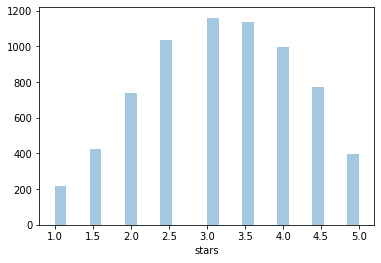

In [29]:
sns.distplot(pandasData['stars'], kde=False);

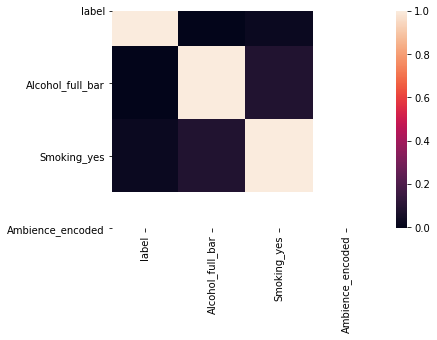

In [30]:
corr_df = pandasData[['label', 'Alcohol_full_bar', 'Smoking_yes', 'GoodForKids', 'Ambience_encoded', 'BikeParking']]
sns.heatmap(corr_df.corr());

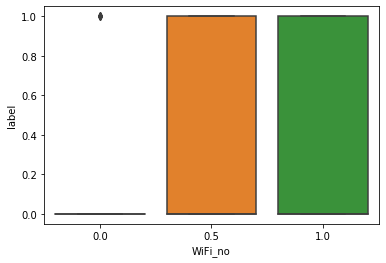

In [31]:
sns.boxplot(x='WiFi_no', y='label', data=pandasData);

In [32]:
train, test = data.randomSplit([0.8, 0.2])

### Test a DecisionTree model

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(100)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages
# summary only
print(treeModel)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  1.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,1.0,0.5,0.5,...|
|       1.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,1.0,0.5,0.5,...|
|       1.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  1.0|[0.5,0.5,0.5,0.5,...|
|       1.0|  1.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  1.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  1.0|[0.5,0.5,0.5,0.5,...|
|       1.0|  0.0|[0.5,0.5,0.5,0.5,...|
|       0.0|  0.0|[0.5,1.0,0.5,0.5,...|
|       0.0|  0.0|[0.5,0.5,0.5,0.5,...|


### Create a SparkTorch Model with torch distributed. Barrier execution is on by default for this mode.

In [37]:
from sparktorch import serialize_torch_obj, SparkTorch
import torch
import torch.nn as nn
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.pipeline import Pipeline

network = nn.Sequential(
        nn.Linear(42, 21),
        nn.ReLU(),
        nn.Linear(21, 10),
        nn.ReLU(),
        nn.Linear(10, 2),
        nn.ReLU()
    )

torch_obj = serialize_torch_obj(
    model=network,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.0001
)

spark_model = SparkTorch(
    inputCol='features',
    labelCol='label',
    predictionCol='predictions',
    torchObj=torch_obj,
    iters=1000,
    verbose=1,
    earlyStopPatience=40,
    validationPct=0.2
)

In [38]:
p = spark_model.fit(data)

In [39]:
predictions = p.transform(data).persist()
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="predictions", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Train accuracy = %g" % accuracy)

Train accuracy = 0.685893
